In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedKFold
import sklearn.metrics as sklm
import numpy as np
import sklearn.model_selection as le_ms
import sklearn.preprocessing as skpp
import xgboost as xgb
import sklearn.utils as sklu
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import hyperopt.hp as hpo 

In [2]:
# Load the Dataset
df = pd.read_csv("/Users/christinsilos/Desktop/Deep Learning - Spring 2026/Homework 1/student_lifestyle_100k.csv")
df

,Student_ID,Age,Gender,Department,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression
0,1001,22,Female,Science,3.50,7.3,3.3,3.4,114,5,False
1,1002,20,Male,Engineering,2.72,5.5,7.2,6.0,142,2,False
2,1003,20,Male,Medical,3.01,5.4,2.3,1.8,137,3,False
3,1004,21,Male,Engineering,3.63,8.1,2.0,4.6,130,3,False
4,1005,19,Male,Arts,3.14,6.8,2.6,4.3,4,6,False
...,...,...,...,...,...,...,...,...,...,...,...
99995,100996,24,Female,Medical,2.02,7.0,0.6,1.4,66,4,False
99996,100997,24,Male,Arts,2.33,5.0,3.6,5.2,103,3,False
99997,100998,24,Female,Engineering,2.23,6.5,5.8,4.1,61,5,False
99998,100999,19,Male,Engineering,3.61,6.1,4.8,4.9,116,4,False


In [3]:
# Drop the student ID column - Not informative for machine learning model
df = df.drop(columns=["Student_ID"])
df

,Age,Gender,Department,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression
0,22,Female,Science,3.50,7.3,3.3,3.4,114,5,False
1,20,Male,Engineering,2.72,5.5,7.2,6.0,142,2,False
2,20,Male,Medical,3.01,5.4,2.3,1.8,137,3,False
3,21,Male,Engineering,3.63,8.1,2.0,4.6,130,3,False
4,19,Male,Arts,3.14,6.8,2.6,4.3,4,6,False
...,...,...,...,...,...,...,...,...,...,...
99995,24,Female,Medical,2.02,7.0,0.6,1.4,66,4,False
99996,24,Male,Arts,2.33,5.0,3.6,5.2,103,3,False
99997,24,Female,Engineering,2.23,6.5,5.8,4.1,61,5,False
99998,19,Male,Engineering,3.61,6.1,4.8,4.9,116,4,False


In [4]:
# Get the counts of the outcome of interest - Depression
df['Depression'].value_counts()

Depression
False    89938
True     10062
Name: count, dtype: int64

In [5]:
# Get Counts of Departments
df['Department'].value_counts()

Department
Science        20071
Engineering    20057
Arts           19998
Medical        19964
Business       19910
Name: count, dtype: int64

In [6]:
# Dummy Code the Categorical Department Variable
df = pd.get_dummies(df, columns=["Department"])
df

,Age,Gender,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression,Department_Arts,Department_Business,Department_Engineering,Department_Medical,Department_Science
0,22,Female,3.50,7.3,3.3,3.4,114,5,False,False,False,False,False,True
1,20,Male,2.72,5.5,7.2,6.0,142,2,False,False,False,True,False,False
2,20,Male,3.01,5.4,2.3,1.8,137,3,False,False,False,False,True,False
3,21,Male,3.63,8.1,2.0,4.6,130,3,False,False,False,True,False,False
4,19,Male,3.14,6.8,2.6,4.3,4,6,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,24,Female,2.02,7.0,0.6,1.4,66,4,False,False,False,False,True,False
99996,24,Male,2.33,5.0,3.6,5.2,103,3,False,True,False,False,False,False
99997,24,Female,2.23,6.5,5.8,4.1,61,5,False,False,False,True,False,False
99998,19,Male,3.61,6.1,4.8,4.9,116,4,False,False,False,True,False,False


In [7]:
# Convert the string Gender variable to numeric values for Model
df["gender_bin"] = df["Gender"].map({
    "Male": 1,
    "Female": 0
})

In [8]:
# Convert the dummy code departmen variables for use in the model
dummy_cols = df.filter(like="Department_").columns
df[dummy_cols] = df[dummy_cols].astype(int)
df

,Age,Gender,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression,Department_Arts,Department_Business,Department_Engineering,Department_Medical,Department_Science,gender_bin
0,22,Female,3.50,7.3,3.3,3.4,114,5,False,0,0,0,0,1,0
1,20,Male,2.72,5.5,7.2,6.0,142,2,False,0,0,1,0,0,1
2,20,Male,3.01,5.4,2.3,1.8,137,3,False,0,0,0,1,0,1
3,21,Male,3.63,8.1,2.0,4.6,130,3,False,0,0,1,0,0,1
4,19,Male,3.14,6.8,2.6,4.3,4,6,False,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,24,Female,2.02,7.0,0.6,1.4,66,4,False,0,0,0,1,0,0
99996,24,Male,2.33,5.0,3.6,5.2,103,3,False,1,0,0,0,0,1
99997,24,Female,2.23,6.5,5.8,4.1,61,5,False,0,0,1,0,0,0
99998,19,Male,3.61,6.1,4.8,4.9,116,4,False,0,0,1,0,0,1


In [9]:
# Convert depression to integer rather than TRUE/FALSE
df["Depression"] = df["Depression"].astype(int)

In [10]:
# Drop Original Gender Column
df = df.drop(columns=["Gender"])

In [11]:
# Separate Predictors from the outcome
X = df.drop(columns=["Depression"])
y = df['Depression']

In [17]:
# Split into Training/Testing Sets
X_train, X_test, y_train, y_test = le_ms.train_test_split(X, y, random_state=12345, train_size=0.75, stratify = y)

columns = X_train.columns

In [13]:
# Specify number of Splits for Cross-Validation
N_SPLITS = 10
kfold = le_ms.StratifiedKFold(n_splits = N_SPLITS)

In [15]:
# set the parameter space and values for the algorithm to search through
space = {'max_depth': hp.quniform("max_depth", 1, 20, 1),
            'gamma': hp.uniform('gamma', 0,25),
            'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
            'reg_lambda': hp.uniform('reg_lambda', 0,250),
            'colsample_bytree': hp.uniform('colsample_bytree', 0,1),
            'min_child_weight': hp.quniform('min_child_weight', 0, 200, 1),
            'n_estimators': 180,
            'eval_metric': 'auc',
            'random_state': [1234],
            'early_stopping': 50,
         'scale_pos_weight': hp.quniform('scale_pos_weight', 0, 200, 1)
}

In [16]:
# Classifier Model
def hyperparameter_tuning(space):
    #classes_weights = sklu.class_weight.compute_sample_weight(
    #class_weight='balanced',
    #y=trainY)
    model = xgb.XGBClassifier(#n_estimators =space['n_estimators'],
                                max_depth = int(space['max_depth']), gamma = space['gamma'],
                                reg_alpha = int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                                colsample_bytree = space['colsample_bytree'], eval_metric = 'auc',scale_pos_weight=int(space['scale_pos_weight']),
        
        
        n_jobs=-1)
   


    model.fit(trainX, trainY, verbose=False)

    #pred = model.predict(testX)
    y_pred = model.predict_proba(testX)
    y_true = np.array(testY)
    y_scores = y_pred[:, 1]

    fpr, tpr, _ = sklm.roc_curve(testY, y_scores)
    #AUC = sklm.roc_auc_score(testY, pred)
    roc_auc = sklm.auc(fpr, tpr)
    #print(roc_auc)
    
    return {'loss':-roc_auc, 'status': STATUS_OK, 'model': model}

In [18]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [19]:
# Run the Model
max_depth_list = []
auc_list = []
gamma_list = []
reg_alpha_list = []
reg_lambda_list = []
col_sample_by_tree_list = []
min_child_weight_list = []
scale_pos_weight_list = []
np.random.seed(1234567)
for train_index, test_index in kfold.split(range(len(y_train)), y = y_train):
    
    # split labels and feature matrix
    trainX = X_train[train_index]
    trainY = y_train[train_index]
    testX = X_train[test_index]
    testY = y_train[test_index]
    rstate = np.random.default_rng(1234) # note that you must set this so that the fmin is reproducible
    # run the algorithm
    #scaler = skpp.MinMaxScaler()
    #scaler.fit(trainX)
    #trainX = scaler.transform(trainX)
    #testX = scaler.transform(testX)
    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate=rstate)

    print(best) # print the best parameter values
    # extract the best model
    best_loss = trials.best_trial['result']['loss'] 
    print(best_loss)

    auc_list.append(best_loss)
    max_depth_list.append(best['max_depth'])
    gamma_list.append(best['gamma'])
    reg_alpha_list.append(best['reg_alpha'])
    reg_lambda_list.append(best['reg_lambda'])
    col_sample_by_tree_list.append(best['colsample_bytree'])
    min_child_weight_list.append(best['min_child_weight'])
    scale_pos_weight_list.append(best['scale_pos_weight'])

100%|██████| 200/200 [00:23<00:00,  8.35trial/s, best loss: -0.7052595663330505]
{'colsample_bytree': 0.0736742017376944, 'gamma': 24.6989903918642, 'max_depth': 20.0, 'min_child_weight': 126.0, 'reg_alpha': 73.0, 'reg_lambda': 49.21422229080114, 'scale_pos_weight': 115.0}
-0.7052595663330505
100%|██████| 200/200 [00:24<00:00,  8.11trial/s, best loss: -0.7155978471572897]
{'colsample_bytree': 0.6645782821891496, 'gamma': 17.89523649453338, 'max_depth': 11.0, 'min_child_weight': 6.0, 'reg_alpha': 79.0, 'reg_lambda': 128.46658840873943, 'scale_pos_weight': 72.0}
-0.7155978471572897
100%|██████| 200/200 [00:20<00:00,  9.97trial/s, best loss: -0.7209228417901246]
{'colsample_bytree': 0.000419277536977502, 'gamma': 16.43636903217277, 'max_depth': 16.0, 'min_child_weight': 23.0, 'reg_alpha': 41.0, 'reg_lambda': 49.71447609666489, 'scale_pos_weight': 62.0}
-0.7209228417901246
100%|██████| 200/200 [00:20<00:00,  9.63trial/s, best loss: -0.7064469634117005]
{'colsample_bytree': 0.84052297422094

In [20]:
# Identify Test Set Performance of Each Iteration
test_set_auc = []
for i in range(0, 10, 1):
    print(i)
    model = xgb.XGBClassifier(
                                max_depth = int(max_depth_list[i]), gamma = gamma_list[i],
                                reg_alpha = int(reg_alpha_list[i]), min_child_weight=min_child_weight_list[i], reg_lambda = reg_lambda_list[i],
                                colsample_bytree = col_sample_by_tree_list[i], eval_metric = 'auc',scale_pos_weight = int(scale_pos_weight_list[i]), n_jobs=-1)


    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict_proba(X_test)
    y_true = np.array(y_test)
    y_scores = y_pred[:, 1]

    fpr, tpr, _ = sklm.roc_curve(y_test, y_scores)
    #AUC = sklm.roc_auc_score(testY, pred)
    roc_auc = sklm.auc(fpr, tpr)
    print(roc_auc)
    test_set_auc.append(roc_auc)

0
0.7102168134179137
1
0.711936307438889
2
0.7099069271274732
3
0.7088754376122628
4
0.710968071933089
5
0.7025113804608419
6
0.7093931319797471
7
0.7095557497797294
8
0.7076530808478019
9
0.7082681053991815


In [21]:
# Identify Best Performing Model on Test Set
print("Maximum AUC position: ",test_set_auc.index(max(test_set_auc)) )

Maximum AUC position:  1


In [22]:
# Pull hyperparameter values for best testing fold
i = test_set_auc.index(max(test_set_auc))#best i

In [23]:
# Confirm model performs as above
model = xgb.XGBClassifier(
                                max_depth = int(max_depth_list[i]), gamma = gamma_list[i],
                                reg_alpha = int(reg_alpha_list[i]), min_child_weight=min_child_weight_list[i], reg_lambda = reg_lambda_list[i],
                                colsample_bytree = col_sample_by_tree_list[i], eval_metric = 'auc',scale_pos_weight = int(scale_pos_weight_list[i]), n_jobs=-1)


model.fit(X_train, y_train, verbose=False)

y_pred = model.predict_proba(X_test)
y_true = np.array(y_test)
y_scores = y_pred[:, 1]

fpr, tpr, _ = sklm.roc_curve(y_test, y_scores)
#AUC = sklm.roc_auc_score(testY, pred)
roc_auc = sklm.auc(fpr, tpr)
print(roc_auc)

0.711936307438889


Text(0.5, 0, 'Xgboost Feature Importance')

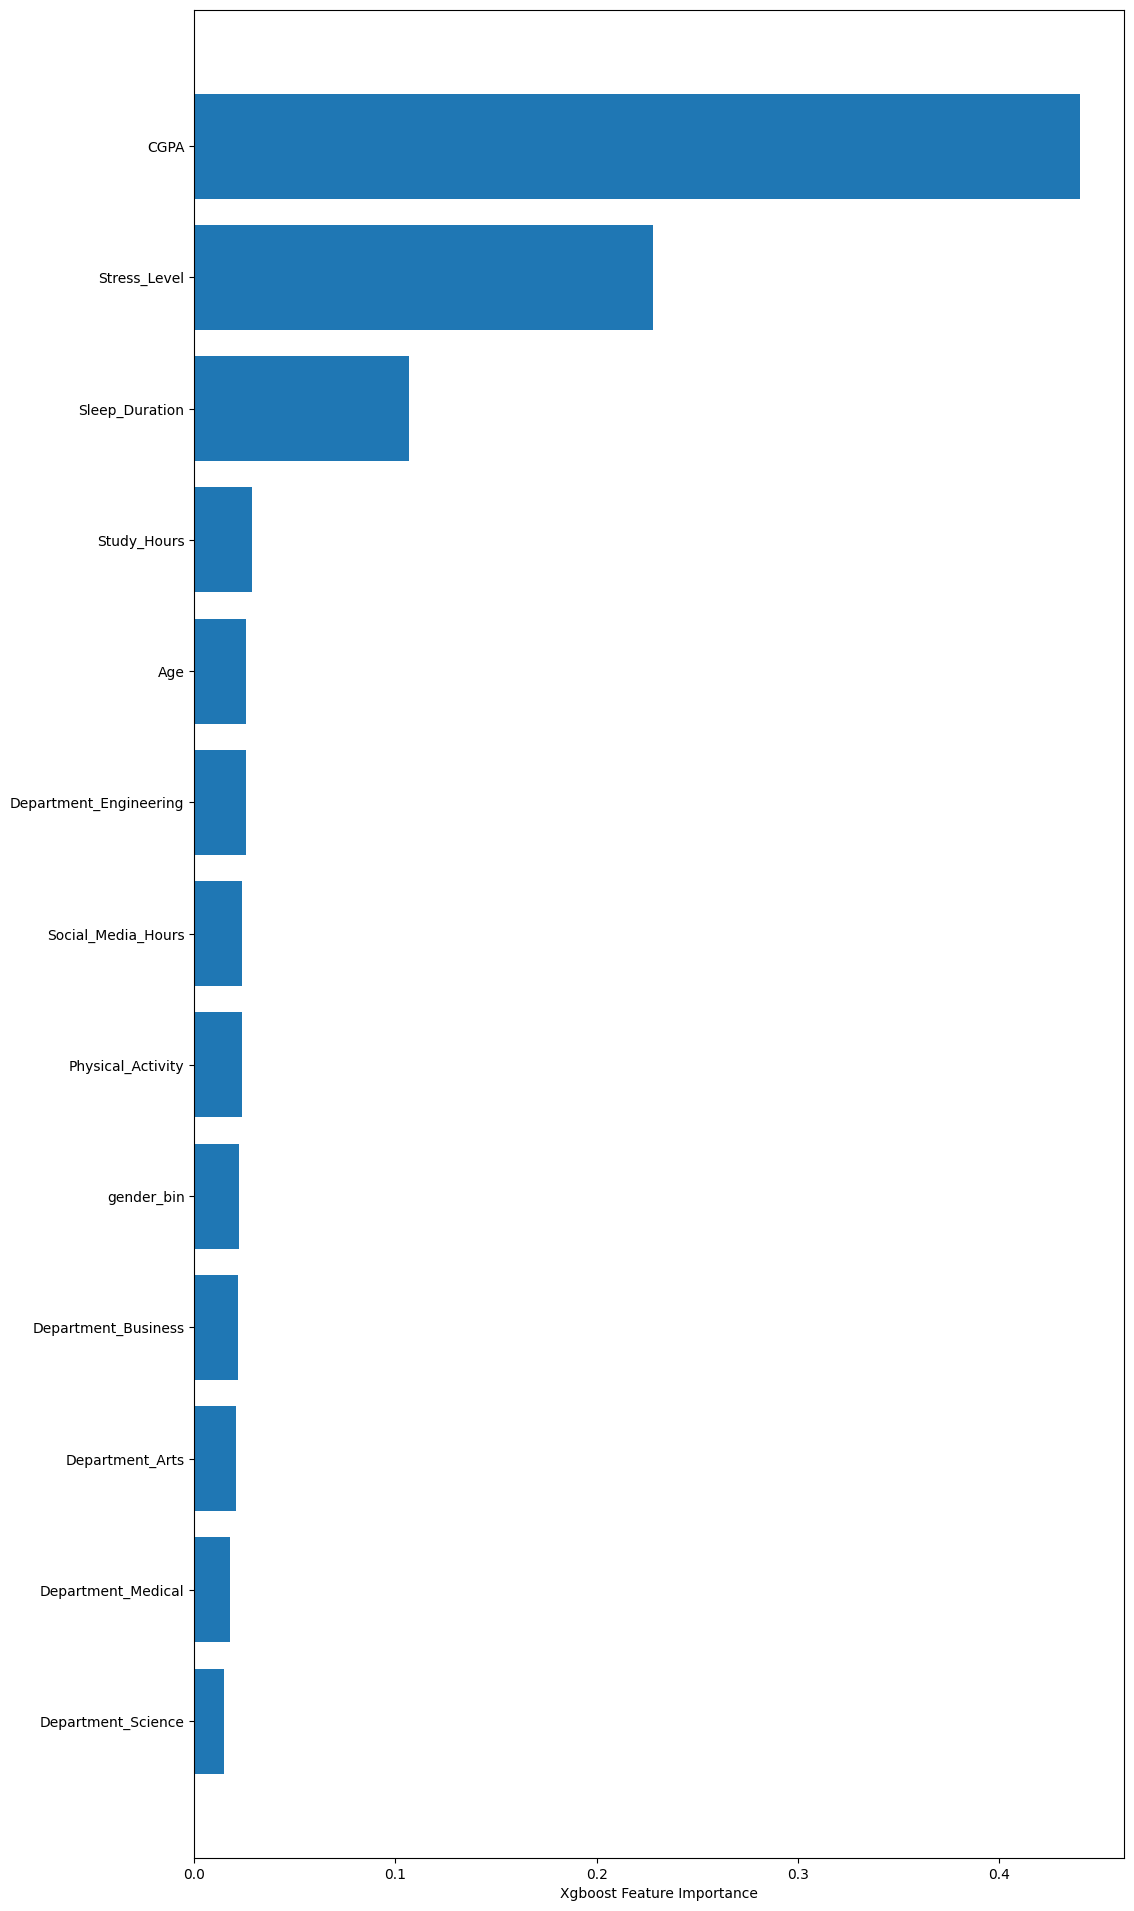

In [24]:
# Feature Importance
sorted_idx = model.feature_importances_.argsort()
fig = plt.figure(figsize=(12, 24)) # set figure size
plt.barh(columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")